In [2]:
# Imports to get and work with files
import os
import csv

# Standard DS 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Image analysis
import cv2
from PIL import Image
from skimage import feature

## Local Binary Paterns or LBP for short
A texture descriptor to compute local representation of texture constructed by comparing each pixel with its surrounding neighborhood of pixels. Another popular texture descriptor would be Haralick texture features but that computes a global representation of texture based on the Gray Level Co-occurance Matrix. We chose to start with LBPs for teh local representation component but it might be worth exploring Haralick texture features in the future.

**Basic steps:**
1. Convert the image to grayscale
2. for each pixel in the grayscale image, select a neighborhood of size 'r' surrounding the center pixel
3. A LBP value is then calculated for this center pixel and stored in the output 2D arraywith the same width and height as the input image
4. The process of thresholding, accumulating binary strings, and storing the output value in the LBP array is repeated for each pixel in the input image
5. The last step is to compute a histogram over the output LBP array --> if using a 3 x 3 neighborhood the are 2^8=256 possible patterns so we can construct a 256-bin histogram of the final image vector.

The main benefit and largest drawback is that we can capture extremely fine-grained details and with a fixed scale. There is an extension to the original LBP implementation to handle variable neighborhood sizes --> moving from a square neighborhood to a circularly symmetric neighborhood made of a number of points 'p' and the radius of the circle 'r' allows us to account for different scales.

Lastly its important to consider the concept of LBP uniformity... (this section will be updated soon with an overview and links to papers)

In [223]:
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        """
        Set the number of points 'p' for the circular neighborhood and the radius 'r'
        for the Local Binary Pattern object needed to calculate the LBP values

        ----------
        Paramaters
        ----------
        numPoints  : int, number of points in the neighborhood used to calculate LBP value.
        radius     : int, radius of the circular neighborhood used to account for dif. scales.

        return     : does not return anything, used to initialize an LBP object and
                     set values for key parameters.
        """

        # set values for the number of points in the circular neighborhood and radius
        self.numPoints = numPoints
        self.radius = radius
        
        
    def describe(self, image, eps=1e-7):
        """
        Compute the Local Binary Pattern representation of the image, and then use the LBP
        representation to build the image histogram and feature vector.
        
        
        ----------
        Parameters
        ----------
        image   : ndarry representing an image.
        eps     : floating point number, very small number used to avoid divide by 0 errors
        
        return  : list of floating point numbers that represetns the image LBP features
        """
        
        # use numPoints and radius to calculate the lbp representation of an image
        lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
        
        # use lbp representation of the image to create a histogram
        (hist, _) = np.histogram( lbp.ravel(),
                                  bins = np.arange(0,self.numPoints + 3),
                                  range = (0, self.numPoints + 2) )
        
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        
        # return the histogram of Local Binary Patterns for the image
        return hist
        
        

### Use Utils to get file names and set up ID's

In [224]:
class ImageSearchUtils:
    """
    Class for utilites, helper functions, and preprocessing / cleaning functions used in the
    Image search engine project
    """
    
    def get_image_file_names(dir_path, make_a_id=False):
        """
        Go to specified directory, find all image/.png files, add them to a list and return that list of names.

        If make_a_id is True, create a_id using image file name to match id's used in other areas of the business
        e.g. change '1980.001.png' to 'a1980_001'

        ----------
        Parameters
        ----------
        dir_path: string, directory path to look through.

        return: list, list of strings of file names.
        """

        # set up empty list which will hold file names
        image_name_list = []

        # loop though directory, check to see if the file is a png and if so add to list
        for file in os.listdir(dir_path):
            # check to see if the file is a .png
            if file.endswith('png'):
                # check to see if make_a_id is True and the file name needs to be changed
                if make_a_id:
                        image_name_list.append('a'+file.replace('.', '_')[:-4])
                # if make_a_id is False get .png file name and add it to list
                else:        
                    image_name_list.append(file)

        # return list of image file names
        return image_name_list



In [7]:
# set path / directory variable to where images are
path = 'Paintings'

# get a list of image file names and a_id names
# .png file names
img_f_names = ImageSearchUtils.get_image_file_names(path)
# a_id formated names
aid_list = ImageSearchUtils.get_image_file_names(path, make_a_id=True)

### Create our LBP object and loop through the images to create the feature vectors

In [116]:
p = 36
r = 12

lbp_desc = LocalBinaryPatterns(p, r)

In [118]:
# open output file for writing
output = open('lbp_image_features_2.csv', 'w')

# loop over both image file names and ID's
for image_path, a_id in zip(img_f_names, aid_list):
   
    # set the image ID
    image_id = a_id
    
    # read the image
    image = cv2.imread(path + '/' + image_path)
    
    # convert the iamge to grayscale and get features
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = lbp_desc.describe(gray)
    
    # write ID and features to the file
    features = [str(f) for f in hist]
    output.write("%s, %s\n" % (image_id, ",".join(features)))

# close the output file
output.close()

## Search to compare images

In [13]:
class SimilarityRanking:
    def __init__(self, indexPath):
        """
        Set directory path for the file of image vectors.
        
        ----------
        Parameters
        ----------
        indexPath : srting, directory path to image vectors.
        
        return    : Doesn't return anythin just sets the indexPath variable
        """
        # set the indexPath to where the image vector file is
        self.indexPath = indexPath
        
        
    def search(self, queryFeatures, metric = 'chi-squared', limit = 10):
        """
        
        """
        
        # initialize results dictionary
        results = {}
        
        # open the file to read image vectors
        with open(self.indexPath) as f:
            # initiate the CSV reader
            reader = csv.reader(f)
            
            # loop over the rows
            for row in reader:
                # parse out the image ID and feature vector, then compute
                # the distance between features in our file and the image
                # being queried
                features = [float(x) for x in row[1:]]
                
                # calculate the distance from the image and the query image
                # default chi-squared but user can choose between those below
                if metric == 'chi-squared':
                    dist = self.chi2_distance(features, queryFeatures)
                elif metric == 'euclidean':
                    pass
                elif metric == 'cosine':
                    pass
                elif metric == 'minkowski':
                    pass
                
                # once we have the distance, upadte results dictionary using
                # the image ID as the key and the distance as the value, the
                # distance represents similar of the image to the query image
                results[row[0]] = dist
                
            # close the reader
            f.close
            
        # sort the results smallest to largest
        results = sorted( [(v, k) for (k, v) in results.items()] )
        
        # return the results limited by limit parameter
        return results[1:limit]
                
    
    def chi2_distance(self, histA, histB, eps = 1e-10):
        """
        
        """
        
        # compute the chi-squared distance
        dist = 0.5 * np.sum( [ ((a - b) ** 2) / (a + b + eps) 
                              for (a, b) in zip(histA, histB) ] )
        
        # return the chi-squared distance
        return dist
        
        

In [225]:
# set an image to query, convert it to grayscale, get the image features
painting = 'Paintings/1964.011.png'
query = cv2.imread(painting)
gray = cv2.cvtColor(query, cv2.COLOR_BGR2GRAY)
features = lbp_desc.describe(gray)

In [226]:
# perform the search
searcher = SimilarityRanking('lbp_image_features.csv')
results = searcher.search(features)

In [227]:
results

[(0.003435533613068227, 'a1959_021'),
 (0.0035593166402424275, 'a1959_040'),
 (0.0036698082776769857, 'a1960_021'),
 (0.00396656443176708, 'a1960_015'),
 (0.0041135437143190925, 'a1958_025'),
 (0.004430182056473344, 'a1960_001'),
 (0.004534646802066788, 'a1960_008'),
 (0.004733926161399822, 'a1960_012'),
 (0.005128777012474205, 'a1959_017')]

In [228]:
result_images = [x[1].replace('a','').replace('_','.') for x in results]

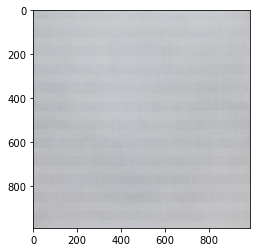

In [229]:
img = Image.open(painting)
plt.imshow(img);

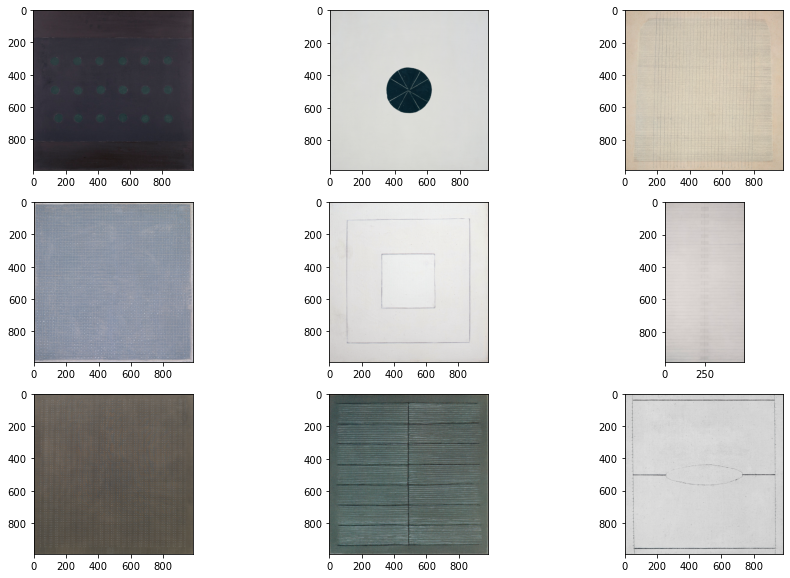

In [230]:
plt.figure(figsize=(15,10)) # specifying the overall grid size
for i in range(9):
    plt.subplot(3,3,i+1)    # the number of images in the grid is 3*3 (9)
    img = Image.open('Paintings/' + result_images[i] + '.png')
    plt.imshow(img)
plt.show()

In [159]:
df = pd.read_csv('image_texture_vectors.csv')
df.head()

,id,Vector
0,1947.001,"[9029.29452753067, 2453.654865026474, 3458.429..."
1,1947.003,"[6515.044216632843, 1265.0005536079407, 1183.1..."
2,1947.006,"[11573.275359153748, 3503.504148721695, 2964.4..."
3,1948.001,"[6957.175195217133, 1308.8055610656738, 1678.4..."
4,1949.001,"[656.4902987480164, 511.90907764434814, 636.63..."


In [161]:
df['Vector'] = df['Vector'].apply(lambda x: x.replace('[', '').replace(']', '').split(','))
df.head()

,id,Vector
0,1947.001,"[9029.29452753067, 2453.654865026474, 3458.4..."
1,1947.003,"[6515.044216632843, 1265.0005536079407, 1183..."
2,1947.006,"[11573.275359153748, 3503.504148721695, 2964..."
3,1948.001,"[6957.175195217133, 1308.8055610656738, 1678..."
4,1949.001,"[656.4902987480164, 511.90907764434814, 636...."


In [172]:
# open output file for writing
output = open('texture_description_vectors.csv', 'w')

# loop over both image file names and ID's
for i in range(len(df)):
   
    # set the image ID
    image_id = aid_list[i]
    
    # write ID and features to the file
    features = [v for v in df['Vector'].loc[i]]
    output.write("%s, %s\n" % (image_id, ",".join(features)))

# close the output file
output.close()

In [174]:
df_2 = pd.read_csv('texture_description_vectors.csv', header=None)
df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,3591,3592,3593,3594,3595,3596,3597,3598,3599,3600
0,a1947_001,9029.294528,2453.654865,3458.429095,6686.381712,10833.049440,8521.971044,4673.764094,2489.601432,7536.838463,...,2022.020894,1932.223183,1771.682181,2831.971071,4824.921917,5770.738396,3374.102922,2132.642709,1694.364041,1659.107377
1,a1947_003,6515.044217,1265.000554,1183.140857,1910.971434,2335.268055,2849.006057,2404.960308,1982.536637,9006.834818,...,2310.438005,16108.167772,1881.342561,1642.649139,2190.535608,4763.109601,1707.645108,1849.473043,1736.256752,6788.456093
2,a1947_006,11573.275359,3503.504149,2964.463752,4549.120650,6321.888725,6645.793452,5673.616343,4636.338849,13001.967765,...,2134.932034,3465.098752,3716.847330,3485.341452,3720.627355,4368.483370,2859.081846,2069.710311,2326.756053,2839.085073
3,a1948_001,6957.175195,1308.805561,1678.486494,1989.579478,2797.016105,4414.930787,4803.336256,3034.151124,8098.161018,...,1461.358907,1839.205001,1653.983857,1707.730241,1596.559509,1623.650438,1529.116788,1294.232557,1370.178310,1546.697959
4,a1949_001,656.490299,511.909078,636.638441,527.648538,16621.432961,467.810906,567.792413,457.949737,580.147083,...,715.414367,5239.929245,386.456033,603.650128,562.885716,4026.415069,711.452435,554.533896,390.647883,3656.209982


In [293]:
df_2[0].loc[333]

'a1985_024'

In [301]:
# set an image to query, convert it to grayscale, get the image features
features = df_2.iloc[333, 1:]

In [302]:
# perform the search
searcher = SimilarityRanking('texture_description_vectors.csv')
results = searcher.search(features)

In [303]:
results

[(46108.92682897607, 'a2003_017'),
 (46127.20396483956, 'a1980_016'),
 (47934.0644370207, 'a2002_006'),
 (49493.713322687574, 'a1967_002'),
 (55479.097890585224, 'a1993_002'),
 (58880.20523656004, 'a1967_011'),
 (63851.00692030486, 'a1984_013'),
 (64635.92639587866, 'a1981_001'),
 (70218.05386773194, 'a1982_004')]

In [304]:
result_images = [x[1].replace('a','').replace('_','.') for x in results]

In [298]:
painting = 'Paintings/1985.024.png'

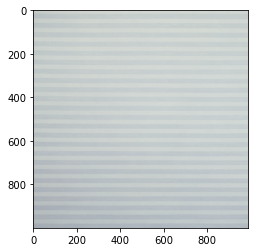

In [299]:
img = Image.open(painting)
plt.imshow(img);

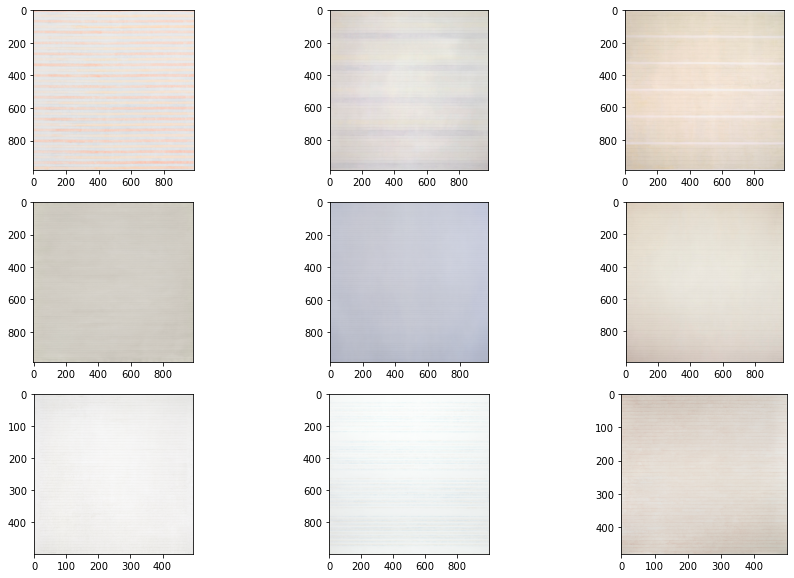

In [305]:
plt.figure(figsize=(15,10)) # specifying the overall grid size
for i in range(9):
    plt.subplot(3,3,i+1)    # the number of images in the grid is 3*3 (9)
    img = Image.open('Paintings/' + result_images[i] + '.png')
    plt.imshow(img)
plt.show()